# Imports

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

from bs4 import BeautifulSoup
import unicodedata

import logging
import re
import copy
import os
import sys
import json
from datetime import datetime
from collections import Counter
import string
import glob
import ast
from tqdm.notebook import tqdm
import xmltodict

from tabulate import tabulate

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import scipy.spatial.distance

import umap

TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
# ----------- NLP modules ----------- #

import gensim
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Modelling with Doc2Vec
---

- The LDA approach of the last notebook relies on a [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model), where each document is converted to a fixed-length vector of integers.
- Each element in the vector counts the number of times a particular word occurs in the document. However, the order of the words in the vector is arbitrary. 
- Bag-of-words models are effective (e.g., as we have seen by ourselves in the LDA notebook). 
- However, the bag-of-word approach has shortcomings. We lose all information about word order and the model won't capture the meaning of the words. E.g., the distance between vectors doesn't necessarily express the difference in meaning.
- [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) is a model that embeds words in a lower-dimensional vector space using a neural network. 
- The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context. 
- If we wanted to calculate a vector for the entire document, we could average the Word2Vec vectors in the document. This can possibly yield sufficient results. However, gensim offers an improved method called [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html).

In this notebook I train such a Doc2Vec model, roughly following [this gensim tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py).

## Load and prepare data

In [4]:
df = pd.read_parquet("_data/podcasts_cleaned.parq")

# Remove all podcast that weren't updated after 2018.
df.releaseDate = pd.to_datetime(df.releaseDate)
to_drop = df[df.releaseDate.dt.year<2019].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(6636, 29)

I'll join texts in all relevant feature columns into one single text feature.

In [5]:
def join_text_columns(data):
    text = []
    for row in data.values:
        if type(row) is str:
            text.append(row)
        elif isinstance(row, (np.ndarray, list)):
            text.append(" ".join(row))
        else:
            assert row is None
            text.append("")
            continue
    return " ".join(text) 

In [6]:
podcast_columns = ['artistName', 'title', 'subtitle', 'summary', "tags", 
                   'ep_titles', 'ep_itunes_titles', 'ep_tags', 'primary_genre',
                   'ep_subtitles', 'ep_summaries', 'ep_contents']
df_pod = df[podcast_columns].apply(join_text_columns, axis=1)    

I'll clean and prepare the aggregated texts:

- [X] Cut the word count per podcast to 10k
- [X] Remove HTML tags
- [X] Keep only ASCII + European Chars, some punctuation and whitespace
- [X] Remove links

In [7]:
RE_ASCII = re.compile(r"[^A-Za-zÀ-žäüöÄÜÖ.!? ]", re.IGNORECASE)
MAX_WORDS = 10_000
REMOVE_LESS_THAN = 2

def clean_text(text):
    
    # Reduce to MAX_WORDS to speed up processing.
    text = " ".join(text.split(" ")[:MAX_WORDS])
    
    # Strip HTML tags.
    text = BeautifulSoup(text, "lxml").get_text()
    
    # Keep only ASCII + European Chars, some punctuation and whitespace
    text = re.sub(RE_ASCII, " ", text)
   
    # Remove links.
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'www.\S+', ' ', text)
    
    # # Remove all words less than 2 digits long.
    # text = " ".join([token for token in text.split(" ") if len(token)>REMOVE_LESS_THAN])
       
    return text

In [8]:
%%time
df_pod = df_pod.apply(clean_text)
df["text"] = df_pod

CPU times: user 30.1 s, sys: 648 ms, total: 30.8 s
Wall time: 30.8 s


With gensim's `simple_preprocess` utility function I remove accents and words that have less than 2 and more than 30 characters.

In [9]:
%%time
df["text_processed"] = df.text.apply(gensim.utils.simple_preprocess, deacc=True, min_len=2, max_len=30)
df.word_count = df.text_processed.apply(len)

CPU times: user 47.8 s, sys: 830 ms, total: 48.6 s
Wall time: 48.6 s


## Train Doc2Vec model

In [15]:
%%time
train_epochs = 40
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df.text_processed.values)]
model = Doc2Vec(documents, vector_size=100, window=5, epochs=train_epochs, min_count=3, workers=8)

2021-12-25 18:09:08,859 : INFO : collecting all words and their counts
2021-12-25 18:09:08,859 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-12-25 18:09:12,410 : INFO : collected 633053 word types and 6636 unique tags from a corpus of 6636 examples and 34942381 words
2021-12-25 18:09:12,410 : INFO : Creating a fresh vocabulary
2021-12-25 18:09:12,932 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=3 retains 268779 unique words (42.45758254048239%% of original 633053, drops 364274)', 'datetime': '2021-12-25T18:09:12.932150', 'gensim': '4.1.2', 'python': '3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:21:17) \n[Clang 11.1.0 ]', 'platform': 'macOS-11.6.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
2021-12-25 18:09:12,932 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 34435942 word corpus (98.55064541823867%% of original 34942381, drops 506439)', 'datetime': '2021-12-25T18:09:12.932539', 'gensim': '4

CPU times: user 36min 55s, sys: 21.2 s, total: 37min 16s
Wall time: 7min 36s


In [16]:
# model.save("_models/gensim_doc2vec_eps40_min3")

2021-12-25 18:21:57,826 : INFO : Doc2Vec lifecycle event {'fname_or_handle': '_models/gensim_doc2vec_eps40_min3', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-12-25T18:21:57.826870', 'gensim': '4.1.2', 'python': '3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:21:17) \n[Clang 11.1.0 ]', 'platform': 'macOS-11.6.1-arm64-arm-64bit', 'event': 'saving'}
2021-12-25 18:21:57,830 : INFO : storing np array 'vectors' to _models/gensim_doc2vec_eps40_min3.wv.vectors.npy
2021-12-25 18:21:58,119 : INFO : storing np array 'syn1neg' to _models/gensim_doc2vec_eps40_min3.syn1neg.npy
2021-12-25 18:21:58,397 : INFO : not storing attribute cum_table
2021-12-25 18:21:58,628 : INFO : saved _models/gensim_doc2vec_eps40_min3


## Get document vectors and evaluate model quality

I now retrieve the document vectors and evaluate the model's quality [with this approach](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#assessing-the-model). This is not at all a precise quality assessment but rather a sanity check.

In [4]:
model = Doc2Vec.load("_models/gensim_doc2vec_eps40_min3")

2022-02-13 13:09:35,466 : INFO : loading Doc2Vec object from _models/gensim_doc2vec_eps40_min3
2022-02-13 13:09:35,521 : INFO : loading dv recursively from _models/gensim_doc2vec_eps40_min3.dv.* with mmap=None
2022-02-13 13:09:35,521 : INFO : loading wv recursively from _models/gensim_doc2vec_eps40_min3.wv.* with mmap=None
2022-02-13 13:09:35,521 : INFO : loading vectors from _models/gensim_doc2vec_eps40_min3.wv.vectors.npy with mmap=None
2022-02-13 13:09:35,555 : INFO : loading syn1neg from _models/gensim_doc2vec_eps40_min3.syn1neg.npy with mmap=None
2022-02-13 13:09:35,589 : INFO : setting ignored attribute cum_table to None
2022-02-13 13:09:36,618 : INFO : Doc2Vec lifecycle event {'fname': '_models/gensim_doc2vec_eps40_min3', 'datetime': '2022-02-13T13:09:36.618559', 'gensim': '4.1.2', 'python': '3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:21:17) \n[Clang 11.1.0 ]', 'platform': 'macOS-11.6.1-arm64-arm-64bit', 'event': 'loaded'}


In [18]:
%%time
ranks = []
second_ranks = []
doc_vectors = []
for doc_id in tqdm(range(len(documents))):
    inferred_vector = model.infer_vector(documents[doc_id].words)
    doc_vectors.append(inferred_vector)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    second_ranks.append(sims[1])

In [5]:
doc_vectors = []
for idx in range(len(model.dv)):
    doc_vectors.append(model.dv[idx])

In [11]:
# save vectors for later use
tmp = pd.DataFrame(doc_vectors)
tmp.columns = tmp.columns.astype(str)
tmp.to_parquet("_models/vectors_doc2vec.parq")

In [14]:
counter = Counter(ranks)

The results are good and within what is to be expected: By far the mayority of documents are most similar to themselves according to the resulting document vectors. 

In [22]:
print(counter)
print(f"{100/len(df)*counter[0]:.2f}% of documents are most similar to themselves.")

Counter({0: 6579, 1: 48, 2: 5, 3: 1, 4: 1, 42: 1, 31: 1})
99.14% of documents are most similar to themselves.


## Plotting documents embeddings using PCA and UMAP

In this step I'll try to get more insights into the embeddings. Like I do in the LDA notebook, I reduce the dimensionality with PCA and UMAP and scatter plot these.

### PCA 

In [29]:
pca = PCA(random_state=0)
embed_pca = pca.fit_transform(doc_vectors)

- Like in the LDA notebook, the curve of explained variance of the PCA'ed vectors is not extremely steep. 
- I derive from that, that gensim's default vector length of 100 dimensions is sensible. It appears to be sufficient and yet not too big to efficiently capture the information in the corpus.
- The first 2 components represent just ~12% of the information. 

The first 2 components of PCA'ed vectors capture 11.62% of the total variance of the data.



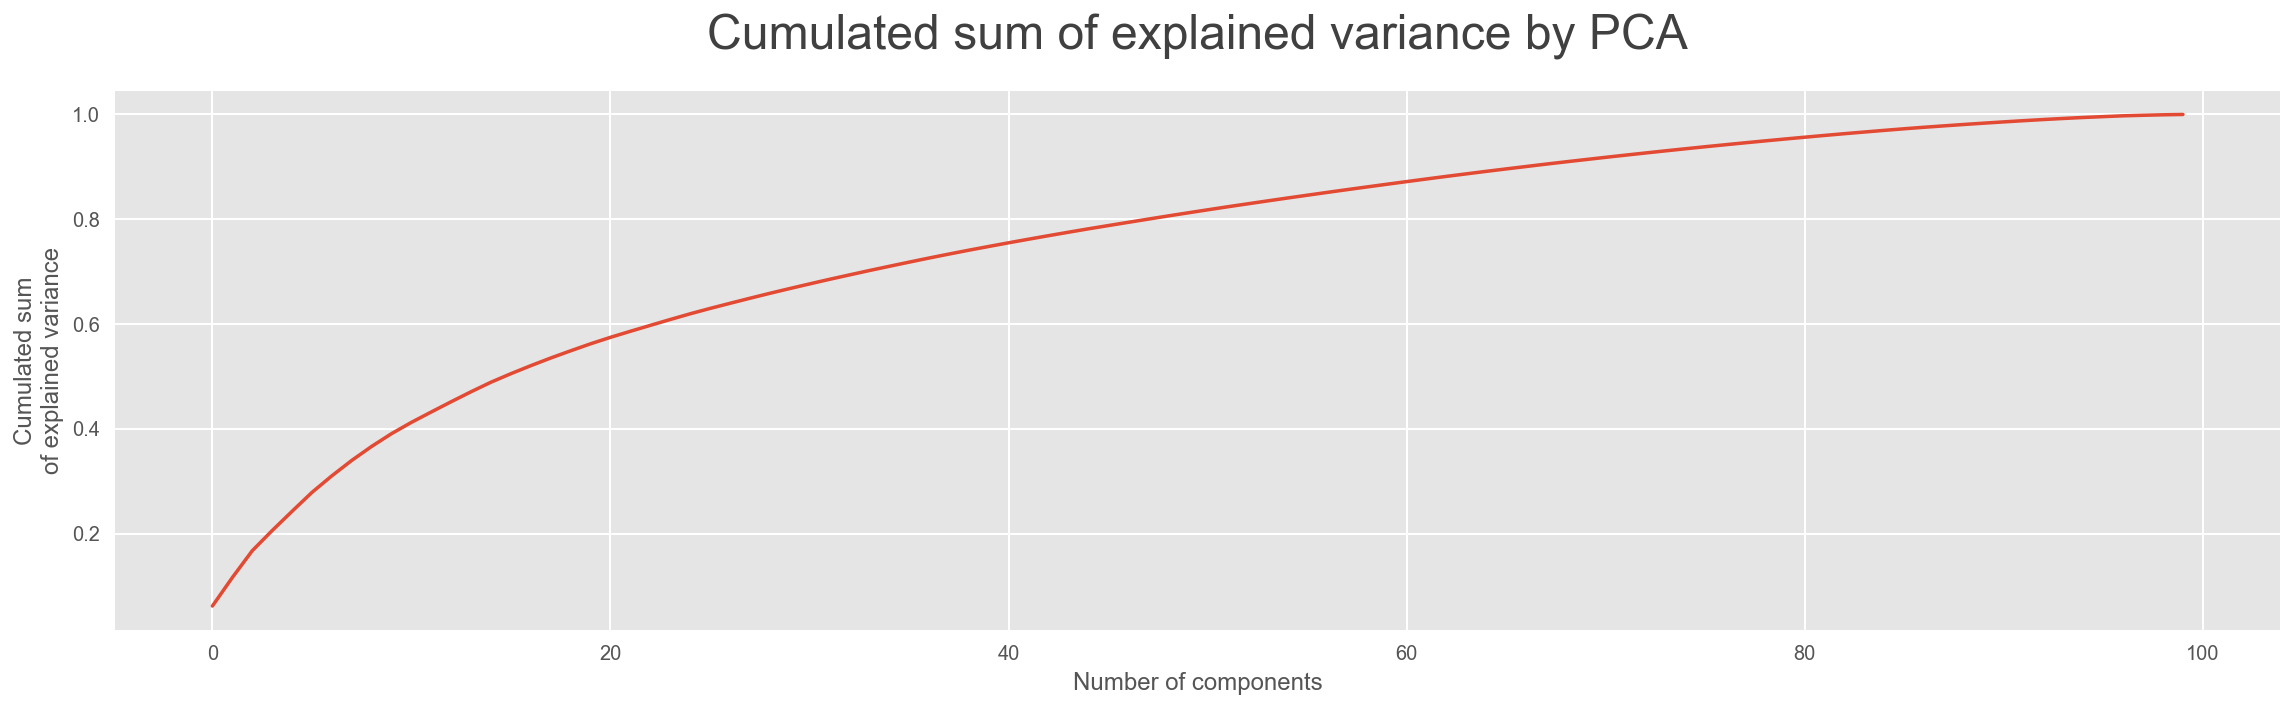

In [30]:
fig, ax = plt.subplots(figsize=(16, 5))
explained_variance = pca.explained_variance_ratio_.cumsum()
print(f"The first 2 components of PCA'ed vectors capture {explained_variance[1]*100:.2f}% of the total variance of the data.\n")

pd.DataFrame(explained_variance).plot(ax=ax)
plt.title("Cumulated sum of explained variance by PCA", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Number of components")
plt.ylabel("Cumulated sum\nof explained variance")
plt.legend([])
plt.tight_layout()
plt.show()

In [31]:
def create_graph(embedding, topic_centers, title_text, xlim=(None, None), ylim=(None, None)):
    fig, ax = plt.subplots(figsize=(16, 16))
    sns.scatterplot(data=embedding, x="x", y="y", 
                    color="lightgrey",
                    palette="tab20", ax=ax, s=10)
   
    for idx, row in topic_centers.iterrows():
        ax.text(row.x, row.y, str(idx), 
                color="darkred",
                fontsize=10, 
                weight='bold',
                horizontalalignment='center', 
                verticalalignment='center'
               )

    ax.set_aspect(1)

    ax.set_facecolor("white")
    plt.title(title_text, size=TITLE_SIZE, pad=TITLE_PAD)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend([])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [34]:
# display(df_embed_pca.min())
# display(df_embed_pca.max())

df_embed_pca = pd.DataFrame(embed_pca[:, :2], columns=["x", "y"])
df_embed_pca["labels"] = df.primary_genre

# I only plot genre labels which have at least min_samples.
min_samples = 20
tmp = df_embed_pca.labels.value_counts()
tmp = tmp[tmp>=min_samples]
relevant_genres = tmp.index.tolist()

genre_centers = df_embed_pca.groupby("labels")[["x", "y"]].mean()
# Reduce dataframe to only include genres that have at least min_samples.
genre_centers = genre_centers.loc[relevant_genres]

- Plotting the individual podcast vectors projected to 2D with PCA in itself doesn't result in any significant visualization. 
- However, grouping the data by primary genre and plotting the averaged position of genres shows a comprehensible distribution of the primary genres. 
- This is promising, since the graph (aka the first 2 components of PCA) only represent ~12% of the document vector information. The actual information of the embedding is much higher. 

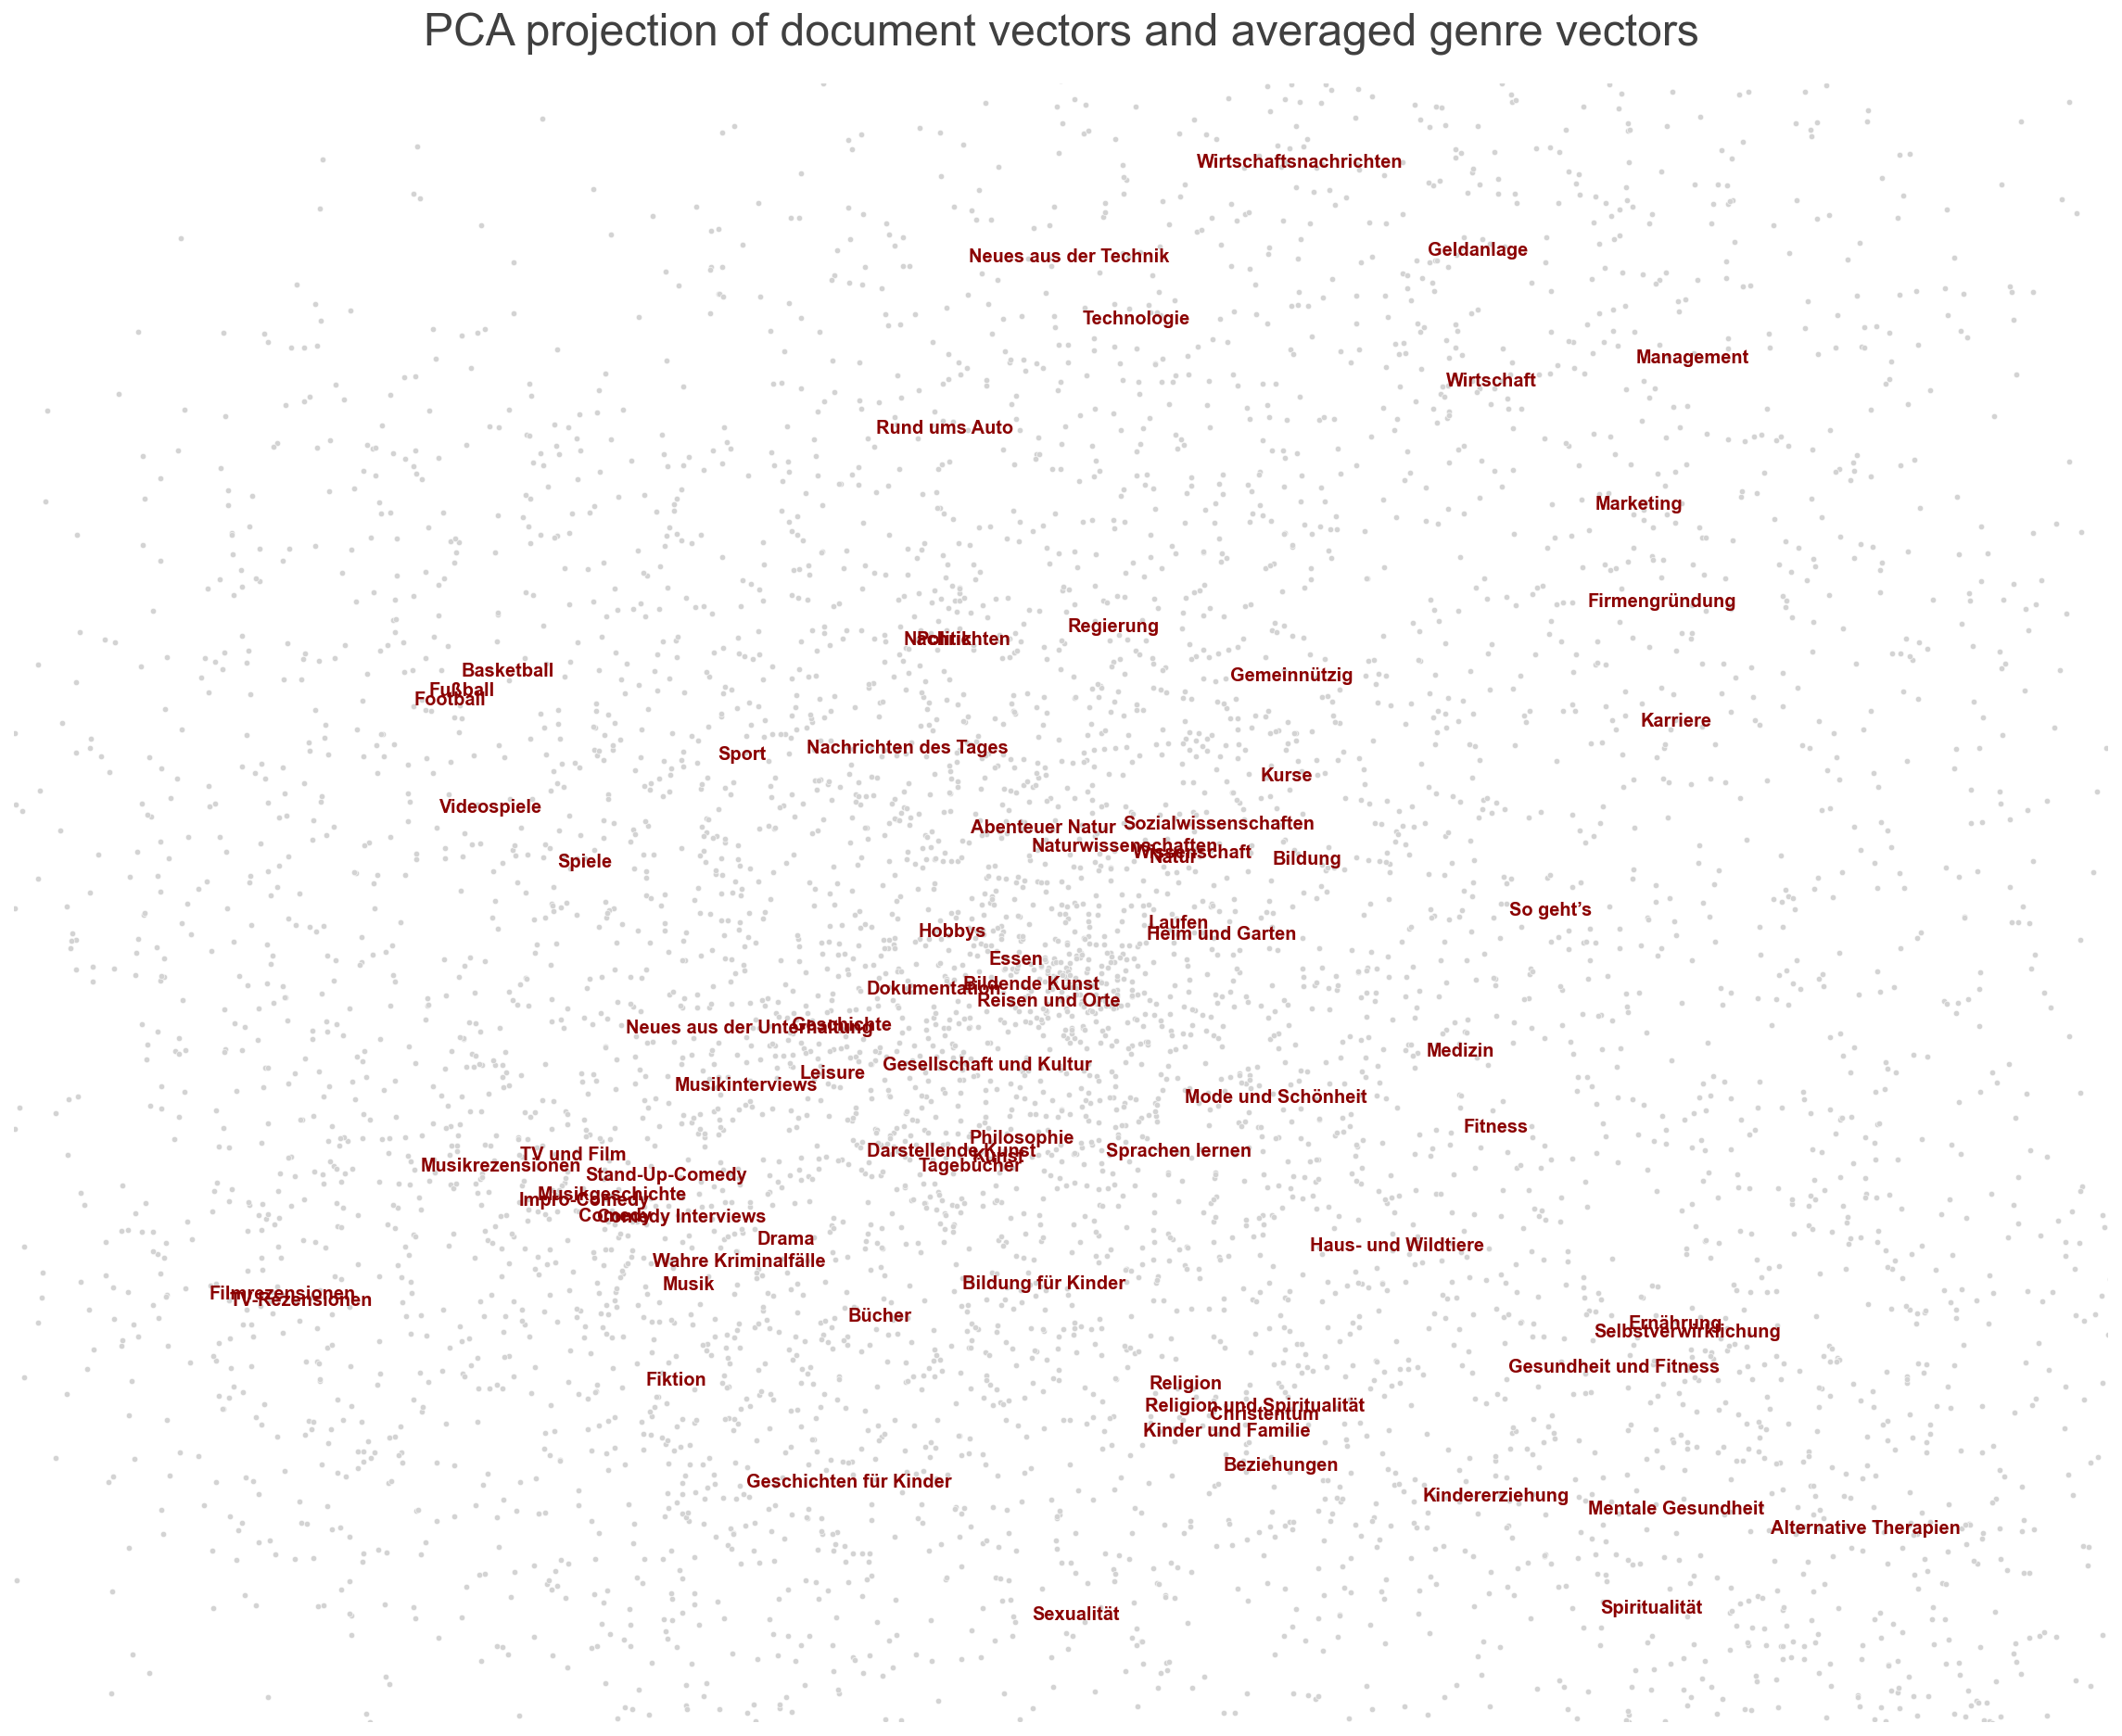

In [34]:
create_graph(df_embed_pca, 
             genre_centers, 
             "PCA projection of document vectors and averaged genre vectors", 
             (-12,11), (-8, 10)
            )

### UMAP

In [28]:
umapper = umap.UMAP(n_neighbors=15, random_state=42)
embed_umap = umapper.fit_transform(doc_vectors)

- The UMAP projection captures much more of the structure in the vector space.
- Again the distribution of the averaged genres is sensible. Genres that have a high similarity, e.g. all sport related genres, are close together in the 2D projection.

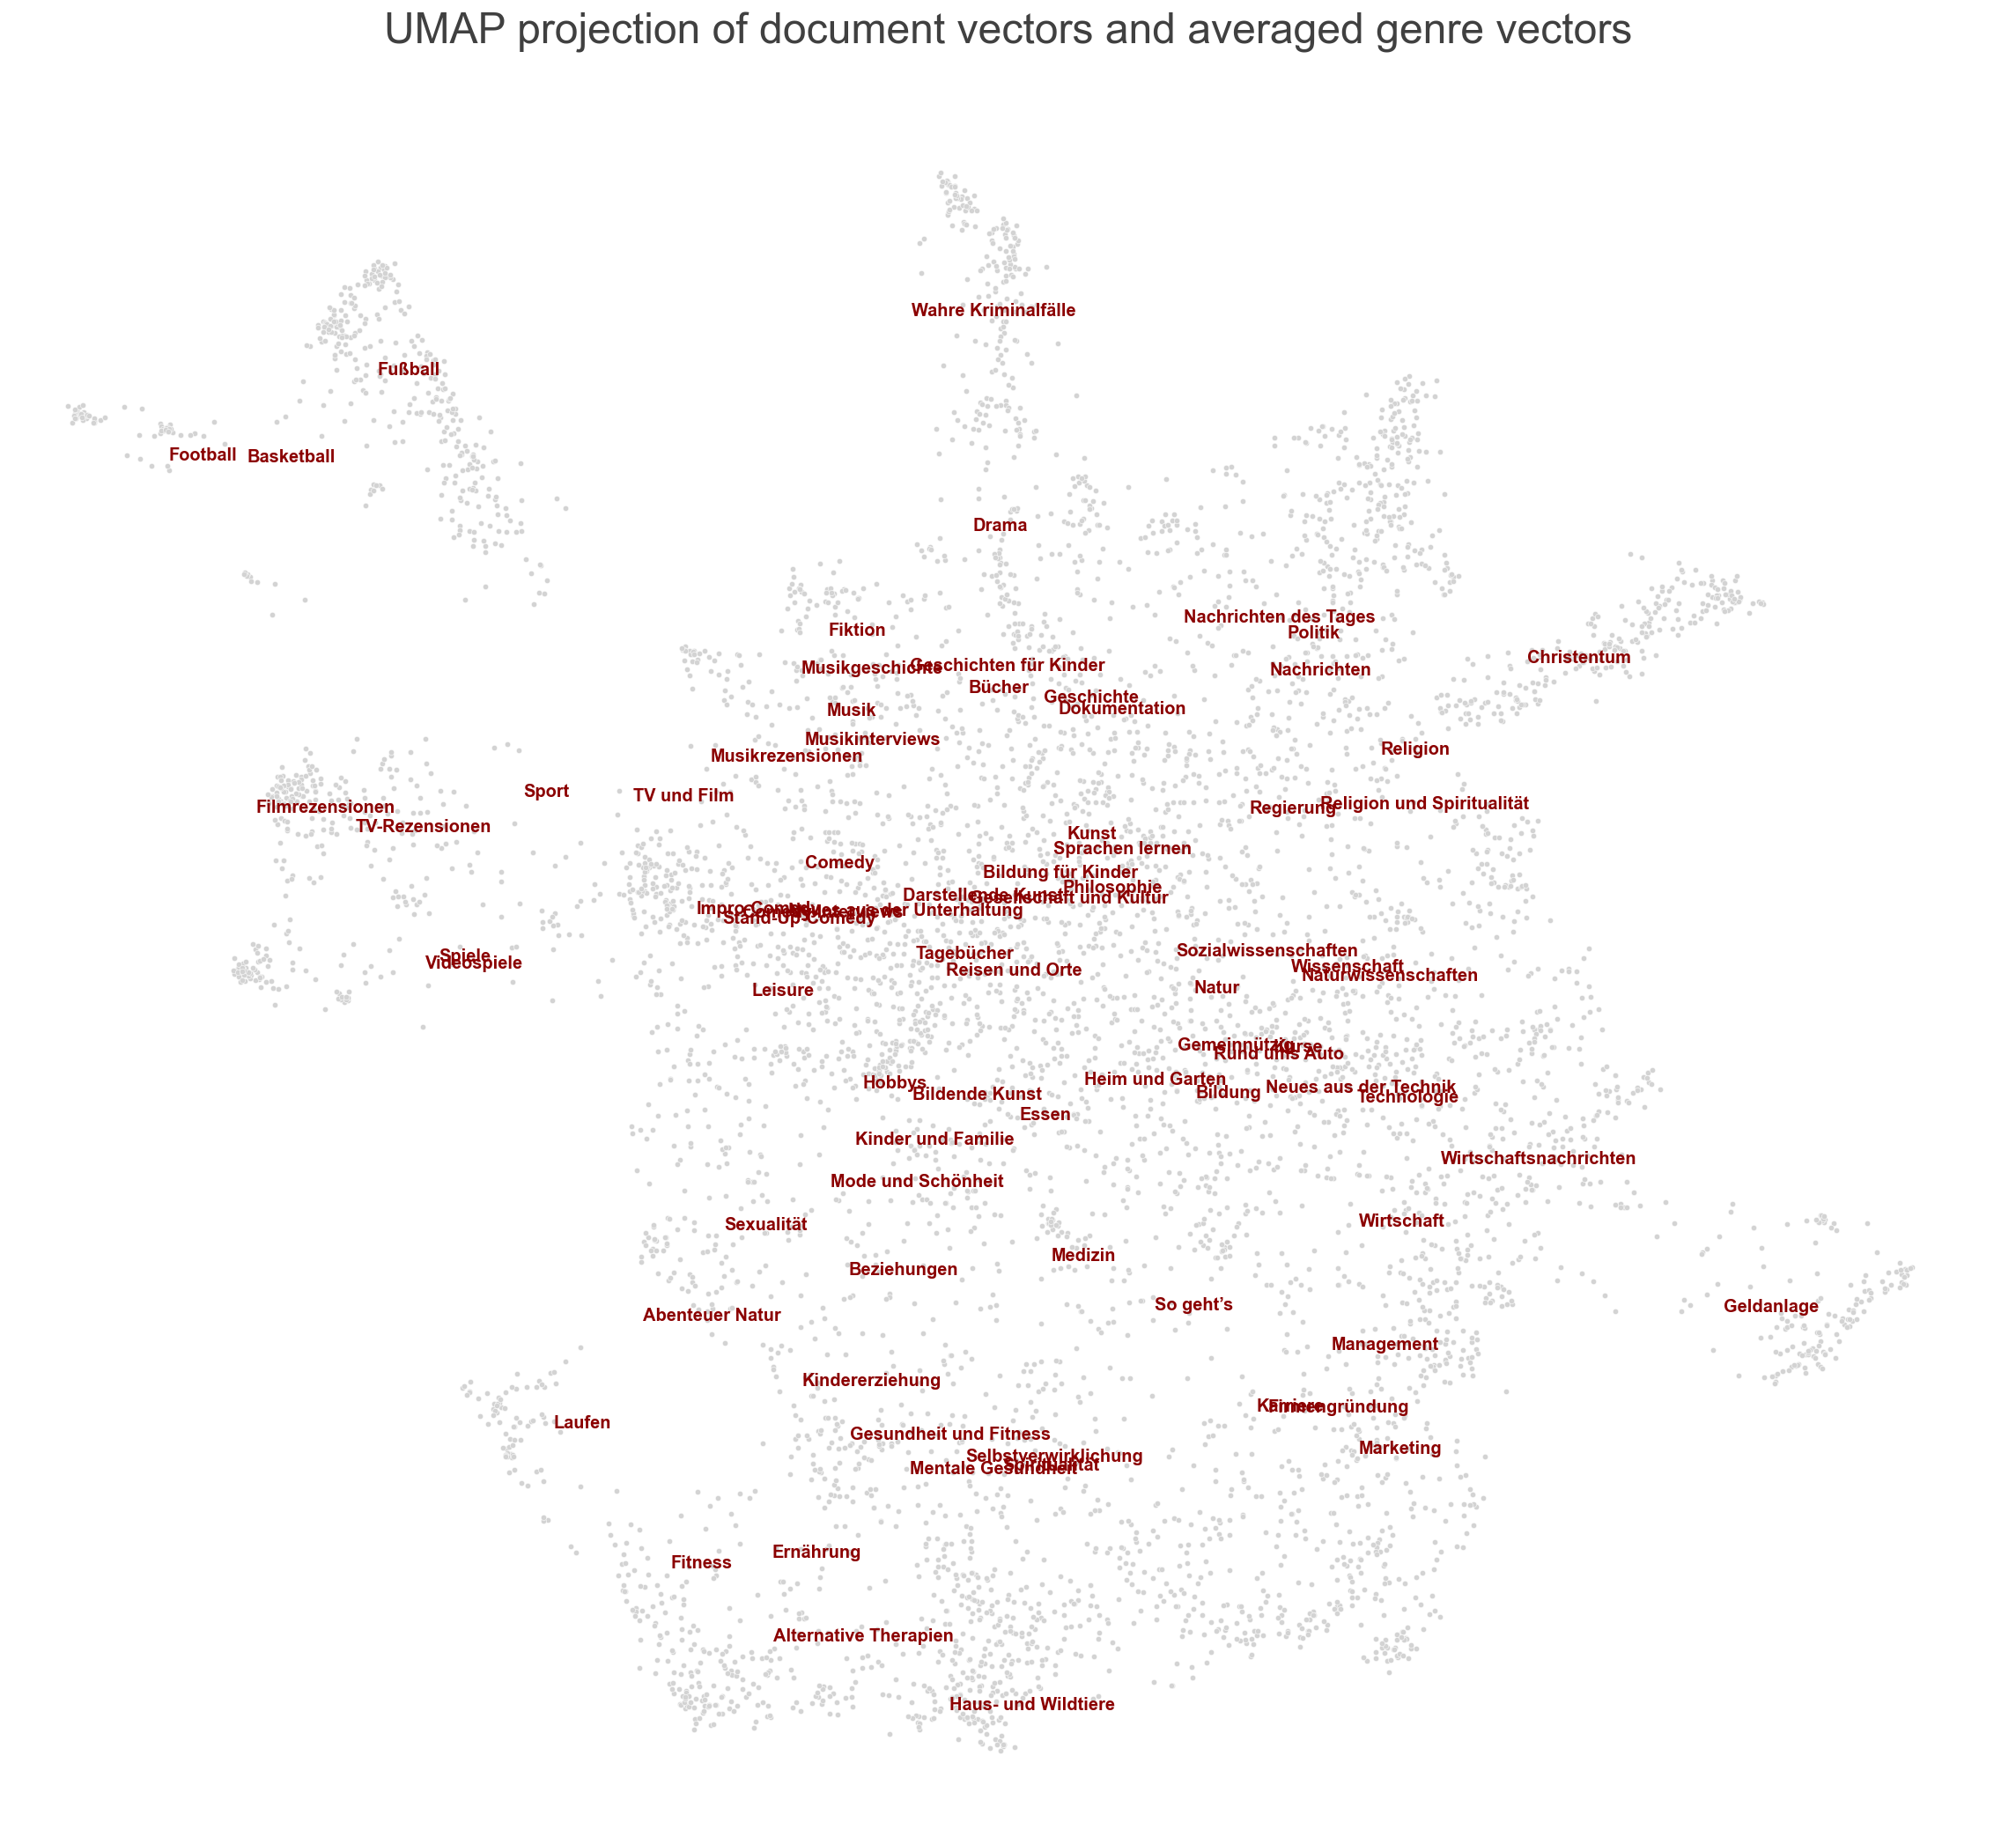

In [38]:
df_embed_umap = pd.DataFrame(embed_umap, columns=["x", "y"])
df_embed_umap["labels"] = df.primary_genre
genre_centers = df_embed_umap.groupby("labels")[["x", "y"]].mean()
genre_centers = genre_centers.loc[relevant_genres]

create_graph(df_embed_umap, 
             genre_centers, 
             "UMAP projection of document vectors and averaged genre vectors", 
            (2, None), (2, None))

## Calculate distances and query similar documents

- By calculating the distances between all vectors I can setup a simple similarity (and dissimilarity) search for the podcasts.
- From manual inspection I observe that the results are meaningful. 

In [39]:
# Calculate distance from every document topic vector to each of all other document vectors.
doc_distances = scipy.spatial.distance.cdist(doc_vectors, doc_vectors, metric="cosine")
print(f"Calculated document distance matrix of shape {doc_distances.shape}.")

Calculated document distance matrix of shape (6636, 6636).


In [46]:
cols_to_show = ['artistName', 'title', 'subtitle', 'summary', 'primary_genre']
min_word_count = 150

def query_similar_podcasts(podcast_title, n_results=10, furthest=False):
    query_idx = df[df.title.str.contains(podcast_title, case=False)].head(1).index.item()
    
    if furthest==False:
        sorted_distances = doc_distances[query_idx].argsort()
        print(f"Closest podcasts to «{podcast_title}».\nFirst entry in list is queried podcast itself.\n")
    else:
        sorted_distances = doc_distances[query_idx].argsort()[::-1]
        print(f"Furthest podcasts to «{podcast_title}».")
    
    # Improve search results by filtering out podcasts that have less describing words than min_word_count.
    display(df.iloc[sorted_distances][df.word_count>=min_word_count][cols_to_show].head(n_results))

In [47]:
query_similar_podcasts("Tagesschau")
query_similar_podcasts("Tagesschau", furthest=True)

Closest podcasts to «Tagesschau».
First entry in list is queried podcast itself.



artistName                                      title  \
3                ARD-aktuell                 Tagesschau (Audio-Podcast)   
544              ARD-aktuell                      Tagesschau (1280x720)   
4778                   WDR 2                            WDR 2 Das Thema   
922   Westdeutscher Rundfunk                      WDR aktuell - Der Tag   
92               ARD-aktuell                Tagesthemen (Audio-Podcast)   
72                        SR                           Bilanz am Mittag   
95                        SR                            Bilanz am Abend   
104   Westdeutscher Rundfunk                       WDR 5 Echo des Tages   
6190  Westdeutscher Rundfunk                           WDR 5 Morgenecho   
2097         Deutschlandfunk  Informationen am Morgen - Deutschlandfunk   

                                               subtitle  \
3     Deutschlands erfolgreichste Nachrichtensendung...   
544   Deutschlands erfolgreichste Nachrichtensendung...   
4778  Alle Stimmen, alle Infos. Alles, was Sie wisse...   
922   WDR aktuell liefert in kompakten zehn Minuten ...   
92                   Die Tagesthemen als Audio-Podcast.   
72    Aktuelles und Hintergründe zu Themen des Tages...   
95    Aktuelles und Hintergründe zu Themen des Tages...   
104   Das Wichtigste des Tages - kompakt in 30 Minut...   
6190  Am Frühstückstisch oder unterwegs zur Arbeit: ...   
2097                           Die Beiträge zur Sendung   

                                                summary  \
3                                                  None   
544                                                None   
4778  Alle Stimmen, alle Infos. Alles, was Sie wisse...   
922   WDR aktuell liefert in kompakten zehn Minuten ...   
92                                                 None   
72    Aktuelles und Hintergründe zu Entwicklungen un...   
95    Aktuelles und Hintergründe zu Entwicklungen un...   
104   Das Wichtigste des Tages - kompakt in 30 Minut...   
6190  Am Frühstückstisch oder unterwegs zur Arbeit: ...   
2097                                               None   

                primary_genre  
3                 Nachrichten  
544               Nachrichten  
4778  Gesellschaft und Kultur  
922     Nachrichten des Tages  
92                Nachrichten  
72                Nachrichten  
95                Nachrichten  
104                   Politik  
6190                  Politik  
2097              Nachrichten

Furthest podcasts to «Tagesschau».


artistName  \
2290                                      Chris Klerner   
6381  Antonia Neumann, Kaj-Ariane Fischer, Dieter Wu...   
205                                 Sascha und Matthias   
908                                      Robert Gladitz   
371                    J-Junk Podcast - Telespieleabend   
3665                                             Marcel   
354       Carsten Tomalla, Timo Zander, Robert Mitchell   
891                                     Hendrik Klöters   
465         by Citizen Circle | Anika Bors & Tim Chimoy   
3157                                      Laura Gollers   

                                                  title  \
2290  vogelfree | Der Podcast zur Selbstverwirklichu...   
6381                                  Unblock Your Life   
205    Lichtspielhaus - Der wirklich wahre Kino Podcast   
908   Effortless Creation - Business für eine neue Z...   
371                    J-Junk Podcast - Telespieleabend   
3665     Shift Your Career | Der Quereinsteiger-Podcast   
354                                        PlayTogether   
891   Der Unternehmerkanal Podcast - mit Hendrik Klö...   
465   Citizen Circle on Air - Community over Competi...   
3157                                            youmoon   

                                               subtitle  \
2290  Der Podcast zur Selbstverwirklichung im Untern...   
6381  Der Podcast voller Inspiration für alle, die i...   
205                     Der wirklich wahre Kino Podcast   
908   Effortless Creation.\nAus der pursten Freude h...   
371                    J-Junk Podcast - Telespieleabend   
3665                                               None   
354   Ein Podcast über Videospiele und Videospielkultur   
891                                                None   
465                                                None   
3157  Der youmoon Podcast ist dein Platz rund um die...   

                                                summary         primary_genre  
2290  vogelfree – Der Podcast zur Selbstverwirklichu...              Karriere  
6381  Unblock Your Life ist der Podcast für alle, di...  Selbstverwirklichung  
205   Im Lichtspielhaus, dem wirklich wahren Kinopod...        TV-Rezensionen  
908   Effortless Creation.\nAus der pursten Freude h...              Karriere  
371   Der Retro-Videospiele Podcast auf J-Junk.de. W...           Videospiele  
3665  Das Interview-Format für Menschen, die etwas i...              Karriere  
354   Videospiele begeistern uns seit eh und je - hi...           Videospiele  
891   Unternehmer werden? "Hör mir auf!" sagen viele...        Firmengründung  
465   Citizen Circle on Air - Der Community Podcast ...        Firmengründung  
3157  Der youmoon Podcast ist dein Platz rund um die...         Spiritualität

In [48]:
query_similar_podcasts("Zum Scheitern Verurteilt")
query_similar_podcasts("Zum Scheitern Verurteilt", furthest=True)

Closest podcasts to «Zum Scheitern Verurteilt».
First entry in list is queried podcast itself.



artistName  \
6456             Laura Larsson & Simon Dömer   
1291  Kevin Klose, Marc Ries, Kevin Albrecht   
2867                         Cosmopolitan DE   
4961                      Julia W. Julia St.   
2227                                89.0 RTL   
4958            Giulia Becker & Chris Sommer   
3791               Tutty Tran & Laura Vetter   
6016            Nina Lippus und Sarah Tropez   
5449                             Jil & Simon   
5610                                    Imke   

                                                  title  \
6456                           Zum Scheitern Verurteilt   
1291                            Drei Nasen talken super   
2867                                  FEMALE AF Podcast   
4961  Forsicht Förderschule! Der Podcast von und mit...   
2227                                    Maribel in Love   
4958                                           DRINNIES   
3791                                          #TeamMayo   
6016                                            FRIEMDS   
5449                                         MIA AUF EX   
5610                                            Ja Moin   

                                               subtitle  \
6456                                               None   
1291                                               DNTS   
2867  Wer schon immer mal wissen wollte, worüber Fra...   
4961  Powerfrauen, Pädagoginnen, Podcaster, 2 Mütter...   
2227  Der Reallife-Podcast von 89.0 RTL - Nach 5 Jah...   
4958  Zwei DRINNIES berichten aus der Komfortzone. G...   
3791                          Liebe geht durch die Mayo   
6016  Der Kennenlern-Podcast von Nina Lippus und Sar...   
5449                                          VIEL WEIN   
5610  Imke hat mit Ihrem Podcast eine neue Beschäfti...   

                                                summary  \
6456  In der Fantasie ist alles möglich. Aber warum ...   
1291  Woche für Woche besprechen Kevin Klose, Marc P...   
2867  Wer schon immer mal wissen wollte, worüber Fra...   
4961  Powerfrauen, Pädagoginnen, Podcaster, 2 Mütter...   
2227  Der Reallife-Podcast von 89.0 RTL - Nach 5 Jah...   
4958  Zwei DRINNIES berichten aus der Komfortzone. G...   
3791  Herzlich willkommen auf dem Podcast-Kanal von ...   
6016  Der Kennenlern-Podcast von Nina Lippus und Sar...   
5449  Braucht es mehr als gute Freundschaft und eine...   
5610  Imke hat mit Ihrem Podcast eine neue Beschäfti...   

                primary_genre  
6456                   Comedy  
1291                   Comedy  
2867  Gesellschaft und Kultur  
4961                   Comedy  
2227               Sexualität  
4958                   Comedy  
3791              Beziehungen  
6016             Impro-Comedy  
5449                   Comedy  
5610  Gesellschaft und Kultur

Furthest podcasts to «Zum Scheitern Verurteilt».


artistName  \
776                 Jan Hoßfeld   
5540                   Uwe Lill   
6564            Domenico Maffei   
2888        LYNX Broker Germany   
3587         Michael Hülskötter   
2807            Mark Poppenborg   
3248              Fabian Merkel   
352                  Karl Urban   
0                 Michael Greth   
5211  Prof. Dr. Christian Rieck   

                                                  title  \
776                                        Follow-Up.fm   
5540  Hedgework-Talk rund um alternative, digitale u...   
6564                                           VC Lunch   
2888                                  Smart Investieren   
3587    IT-techBlog-Podcast (KI, Cloud, Security & Co.)   
2807    MarkUp: Der Podcast von und mit Mark Poppenborg   
3248                                    AI for Business   
352                                    AstroGeo Podcast   
0      SharePointPodcast - Der Modern Workplace Podcast   
5211                          Prof. Dr. Christian Rieck   

                                               subtitle  \
776                  Der Podcast für Nachfolge-StartUps   
5540  Hedgework-Interviews rund um alternative, nach...   
6564  Persönliche und lehrreiche Einblicke in die Ve...   
2888  Smart Investieren - Mehr Wissen für Ihre erfol...   
3587  Podcasts zu Künstlicher Intelligenz, Cloud, IT...   
2807                                               None   
3248      Artificial Intelligence und Daten im Business   
352                                    AstroGeo Podcast   
0     Themen.Trends.Tipps.Tricks.Talk. mit Michael G...   
5211  Hier finden Sie die Tonspuren, zu meinen wöche...   

                                                summary        primary_genre  
776   Start-Ups haben die Geschäftswelt nachhaltig v...           Wirtschaft  
5540  Hedgework-Talk ist der Podcast von Hedgework. ...           Management  
6564  Persönliche und lehrreiche Einblicke in die Ve...       Firmengründung  
2888  Smart investieren? Ist der Podcast rund um das...           Geldanlage  
3587  Für meine Podcasts lade ich regelmäßig interes...          Technologie  
2807  Der intrinsify Gründer Mark Poppenborg ist ein...           Management  
3248                                               None           Wirtschaft  
352   Ein Podcast über Steine, Sterne, Planeten, Mon...  Naturwissenschaften  
0     Das Urgestein unter den Podcasts - seit 7.2.20...          Technologie  
5211  Hier finden Sie die Tonspuren, zu meinen wöche...         Wissenschaft

In [49]:
query_similar_podcasts("Alles gesagt")
query_similar_podcasts("Alles gesagt", furthest=True)

Closest podcasts to «Alles gesagt».
First entry in list is queried podcast itself.



artistName  \
1497                         ZEIT ONLINE   
1874  Frankfurter Allgemeine Zeitung FAZ   
1898                  Auf die Ohren GmbH   
1239        DIE ZEIT // Freunde der ZEIT   
4685                        Pool Artists   
4735                       ZEIT-Stiftung   
481                         Lucky & Fred   
5970                                  hr   
3252                       Mit Vergnügen   
2332          Junge ARD-Programme & funk   

                                                 title  \
1497                                     Alles gesagt?   
1874              FAZ Am Tresen - Der Gesprächspodcast   
1898                                 1 Thema, 2 Farben   
1239                   DIE ZEIT: Hinter der Geschichte   
4685                NBE - Die Nilz Bokelberg Erfahrung   
4735                                      Zwischenrufe   
481                                       Lucky & Fred   
5970                FREIHEIT DELUXE mit Jagoda Marinic   
3252           Heute in 5 Jahren - Der Zukunftspodcast   
2332  Deutschland3000 - 'ne gute Stunde mit Eva Schulz   

                                               subtitle  \
1497                    Der unendliche Interviewpodcast   
1874                                               None   
1898           Christian Lindner im Gespräch mit Gästen   
1239  Der Podcast für Freunde der ZEIT. Jede Woche b...   
4685                                   Come as You Are.   
4735                                               None   
481           Der Podcast mit Heinser und Küppersbusch.   
5970                                               None   
3252  Mit Vergnügen wagt zusammen klugen Denker*inne...   
2332                                               None   

                                                summary  \
1497  Wir befragen außergewöhnliche Menschen - so la...   
1874  Am Tresen der Trinkhalle bleibt man kurz stehe...   
1898  Christian Lindner trifft im Deutschen Bundesta...   
1239  Im neuen ZEIT Podcast berichten unsere Redakte...   
4685  Herzlich Willkommen im Wohnzimmerstudio von Ni...   
4735  Zum 50. Jubiläum der ZEIT-Stiftung Ebelin und ...   
481                                                None   
5970                                               None   
3252  Mit Vergnügen wagt zusammen mit klugen Denker*...   
2332  Wenn man jemand anderen kennenlernt, erfährt m...   

                primary_genre  
1497  Gesellschaft und Kultur  
1874  Gesellschaft und Kultur  
1898                  Politik  
1239              Nachrichten  
4685  Gesellschaft und Kultur  
4735              Philosophie  
481               Nachrichten  
5970  Gesellschaft und Kultur  
3252  Gesellschaft und Kultur  
2332            Dokumentation

Furthest podcasts to «Alles gesagt».


artistName  \
1352       Fachtierärztin für Pferde Dr. Veronika Klein   
4407                                        Anne Bucher   
4094                             Tierheilpraxis Prester   
4664  Katrin Knispel, Katzenpsychologin - Mentorin f...   
1670                                   Christina Reindl   
1095                                        Kiki & Lisa   
3870                                      Sonja Neuroth   
5599                       Pferde-Expertin Sandra Fencl   
6191                                Channeling Kongress   
1512                                        Linda Giese   

                                                  title  \
1352  Kernkompetenz Pferd - Pferdegesundheit mit Tie...   
4407                      Anders mit Hund – Anne Bucher   
4094                             Tierheilpraxis Prester   
4664  Verstehe deine Katze Podcast, Katzenverhalten ...   
1670                    Das kannst DU von Tieren lernen   
1095  Pawsitive Life | Der Podcast für dich und dein...   
3870  Seelenfreunde Tier Talkshow - Die Expertenrund...   
5599  Pferdewissen - ganzheitlich & inspirierend mit...   
6191  Channeling Kongress | Botschaften aus der Geis...   
1512  Lebe glücklich mit Linda Giese – Dein Podcast...   

                                               subtitle  \
1352  Tierarzt, Chiropraktiker, Trainer - Dein Podca...   
4407             Bedürfnisorientiertes Leben mit Hunden   
4094                          Gesundheit für dein Tier!   
4664                       Verstehe deine Katze Podcast   
1670  Wie DU von den Eigenschaften & Verhalten der T...   
1095           Deine Online-Hundeschule mit Kiki & Lisa   
3870  Seelenfreunde Tier Talkshow - Online Talkshow ...   
5599  Dein Podcast über Pferdetraining, Pferdegesund...   
6191  Schön, dass Du den Weg zum Podcast des Channel...   
1512                       Dein Podcast für deine Seele   

                                                summary        primary_genre  
1352  Willkommen bei dem Podcast Kernkompetenz Pferd...              Bildung  
4407  Anders mit Hund - Dein Podcast für ein befürfn...              Bildung  
4094  Wir sind eine Tierheilpraktikerschule im Münst...              Medizin  
4664  Mit mir zum \nunschlagbaren Mensch - Katze - T...  Haus- und Wildtiere  
1670  Wie DU von den Eigenschaften & Verhalten der T...              Bildung  
1095  Wir sind Kiki und Lisa von Pawsitive Life Coac...  Haus- und Wildtiere  
3870  Seelenfreunde Tier Talkshow - Online Talkshow ...  Haus- und Wildtiere  
5599  Dein Pferdepodcast über Pferdetraining, Pferde...               Hobbys  
6191  Schön, dass Du den Weg zum Podcast des Channel...        Spiritualität  
1512  Dieser Podcast richtet sich an dich, wenn du m...        Spiritualität

In [50]:
query_similar_podcasts("Beste Freundinnen")
query_similar_podcasts("Beste Freundinnen", furthest=True)

Closest podcasts to «Beste Freundinnen».
First entry in list is queried podcast itself.



artistName  \
571                        Auf die Ohren   
1788                       Tabea Jendges   
2746  Leonie Rachel Soyel, Sinah Edhofer   
1410      Vero Gottschling & Maxie Eixam   
1313                   Anna Zimt & Paula   
1391                       Auf die Ohren   
2867                     Cosmopolitan DE   
1764                 Paula Lambert, SIXX   
3534      SWR3, Max Oehl, Sabrina Kemmer   
2321                        Chris & Toni   

                                                  title  \
571                                   Beste Freundinnen   
1788                                      Feminine Vibe   
2746                                     Couchgeflüster   
1410                                 Schwarzes Konfetti   
1313  Schnapsidee - der Podcast über Liebe, Love & s...   
1391                                 Beste Vaterfreuden   
2867                                  FEMALE AF Podcast   
1764                                        Paula KOMMT   
3534               Doktorspiele – Liebe, Sex, Beziehung   
2321                                         Hinternhof   

                                               subtitle  \
571                                   Beste Freundinnen   
1788  Weiblichkeit, Sexualität, Dating, Beziehung, S...   
2746                               mit Leonie und Sinah   
1410                                               None   
1313  Anna Zimt und Paula reden und lachen über "Lie...   
1391                                               None   
2867  Wer schon immer mal wissen wollte, worüber Fra...   
1764                         Der Podcast des Scheiterns   
3534  Wir kennen keine Tabus! Sabrina und Max sprech...   
2321                                               None   

                                                summary  \
571   Das ist der ultra ehrliche Männerpodcast. Zwei...   
1788  Feminine Vibe ist der Podcast, der deine weibl...   
2746  Beziehungsprobleme, One-Night-Stands, Dating, ...   
1410  Willkommen zu Schwarzes Konfetti – der Podcast...   
1313  Anna Zimt und Paula reden und lachen über "Lie...   
1391  Fernab von Klischees, besprechen Max und Jakob...   
2867  Wer schon immer mal wissen wollte, worüber Fra...   
1764  Den Müll nicht rausgebracht? Beim Fußball gest...   
3534  Bei Liebe, Sex und Beziehungen kennen wir kein...   
2321  Mit Chris und Toni - einem schwulen Paar aus D...   

                primary_genre  
571                    Comedy  
1788            Spiritualität  
2746               Sexualität  
1410               Tagebücher  
1313                   Comedy  
1391       Kinder und Familie  
2867  Gesellschaft und Kultur  
1764              Beziehungen  
3534               Sexualität  
2321               Sexualität

Furthest podcasts to «Beste Freundinnen».


artistName  \
1483          Cloud Computing Report   
4966                            JUNG   
2652  Redaktion "Datenschutz PRAXIS"   
2361                   Markus Zahner   
2601                 Sound&Recording   
5543                Onlineteam ZMSBw   
3968                    Stefan Wendt   
2741                      Mario Jung   
539                       neunetz.fm   
6                    Deutschlandfunk   

                                           title  \
1483              Cloud Computing Report Podcast   
4966       WECHSELSPANNUNG – Der Branchenpodcast   
2652            Datenschutz PRAXIS - Der Podcast   
2361                         mz Business Podcast   
2601           Sound&Recording - Musikproduktion   
5543             ZUGEHÖRT! Der Podcast des ZMSBw   
3968  GO INBOUND - Der Inbound-Marketing Podcast   
2741                                 OMT Podcast   
539                                   neunetz.fm   
6            Forschung aktuell - Deutschlandfunk   

                                               subtitle  \
1483                              Arbeiten in der Wolke   
4966                                               None   
2652                                               None   
2361                                               None   
2601                          Recording.Producing.Music   
5543  Informatives aus der Arbeit des ZMSBw zu Milit...   
3968                                               None   
2741                                               None   
539                             Alle Shows, alle Folgen   
6                              Die Beiträge zur Sendung   

                                                summary  \
1483  Der Cloud Computing Report Podcast liefert akt...   
4966  WECHSELSPANNUNG ist das JUNG Format für Fachpa...   
2652  Besser mal nachfragen: Im Podcast von Datensch...   
2361  Spannendes aus der Welt der Wirtschaft finden ...   
2601  ​Bei uns dreht sich alles um die Themen Musik ...   
5543  Informatives aus der Arbeit des ZMSBw zu Milit...   
3968  Der Podcast für Unternehmer und Unternehmen, d...   
2741  Der Online Marketing Podcast von OMT-Gründer M...   
539   Hier sind alle Folgen aller Shows des Podcastn...   
6                                                  None   

               primary_genre  
1483   Neues aus der Technik  
4966                   Kurse  
2652  Wirtschaftsnachrichten  
2361              Wirtschaft  
2601         Musikinterviews  
5543    Sozialwissenschaften  
3968               Marketing  
2741               Marketing  
539              Technologie  
6               Wissenschaft

In [51]:
query_similar_podcasts("Finanzfluss")
query_similar_podcasts("Finanzfluss", furthest=True)

Closest podcasts to «Finanzfluss».
First entry in list is queried podcast itself.



artistName  \
3167                       Finanzfluss   
513                 Stefan Obersteller   
643   Albert Warnecke und Daniel Korth   
3362              Der Kostenoptimierer   
594                    Kolja Barghoorn   
2300                       Sven Stopka   
4470               Saidi von Finanztip   
2179                         Jens Rabe   
2597             Thomas der Sparkojote   
3389                          Talerbox   

                                                  title  \
3167                                Finanzfluss Podcast   
513   Geldbildung.de - Finanzielle Bildung über Börs...   
643   Der Finanzwesir rockt - Der etwas andere Podca...   
3362  DER KOSTENOPTIMIERER PODCAST - MEHR GELD, MEHR...   
594     Aktien mit Kopf - Investieren für Privatanleger   
2300  Finanzpodcast | Vermögensaufbau abseits der Masse   
4470  Geld ganz einfach - Der Podcast mit Saidi von ...   
2179     Jens Rabe - Der Börsen-Podcast für Unternehmer   
2597                       Finanzrudel Audio Experience   
3389                Talerbox - Invest smart statt hart!   

                                               subtitle  \
3167                                               None   
513                Finanzielle Bildung - Geldbildung.de   
643              Für Leute, die ihr Geld selbst anlegen   
3362                                               None   
594   Der Aktien Podcast von Privatanlegern für Priv...   
2300  Klartext in Sachen Vermögensaufbau, Investment...   
4470                                               None   
2179    Der neue Podcast für Investoren und Unternehmer   
2597                       Finanzrudel Audio Experience   
3389  Aktien, Börse, Geld anlegen oder Finanzen? Du ...   

                                                summary   primary_genre  
3167  Auch du kannst lernen, mit Geld umzugehen! Wir...      Geldanlage  
513   Der Finanzpodcast, der Dir hilft Anlagefehler ...      Geldanlage  
643   Hallo, wir sind Daniel, ein Ex-Berliner, und A...      Geldanlage  
3362  Du willst mehr Geld, mehr Zeit und mehr Lebens...      Geldanlage  
594   Aktien kaufen? "Hör mir auf" sagen viele Mensc...      Geldanlage  
2300  Finanzen sind für viele ein umfangreiches aber...      Geldanlage  
4470  Wie kriegst Du es hin, am Monatsende mehr Geld...      Geldanlage  
2179  Hallo, mein Name ist Jens Rabe (YouTube: "Opti...      Geldanlage  
2597  Mein Name ist Thomas Kovacs (25) aka Sparkojot...  Firmengründung  
3389  Aktien, Börse, Geld anlegen oder Finanzen? Du ...      Geldanlage

Furthest podcasts to «Finanzfluss».


artistName  \
1945                  Christine Birkel & Sina Kaiser   
3104                                   Brüder Popken   
128                                       NDR Kultur   
1238                                      Erik Hauth   
2024                                        Eva Karl   
1354  Coffee and Chainrings Mountainbike Verein e.V.   
4776          Bühnen & Orchester der Stadt Bielefeld   
656         Inh. Alex Horvath, Inh. Ben Frauenknecht   
3344                            Bayerischer Rundfunk   
707              Schweizer Radio und Fernsehen (SRF)   

                                                  title  \
1945       No Niin! Finnland, Skandinavien & Nordeuropa   
3104      Plattfuß- der Triathlon Podcast für die Rolle   
128                               NDR Kultur - Neue CDs   
1238               St. Pauli POP | der Podcast vom Kiez   
2024                                            EsLafft   
1354                      Coffee and Chainrings Podcast   
4776                       Bühnen & Orchester Bielefeld   
656                                   Jeden Tag Ein Set   
3344  Der Klavierpodcast mit Igor Levit und Anselm C...   
707                                      SRF 3 punkt CH   

                                               subtitle  \
1945  Ein Podcast rund um den hohen Norden Europas m...   
3104  Zwei Brüder – ein Ziel\nBegleitet uns auf unse...   
128   Die wichtigsten und spannendsten Neuerscheinun...   
1238  „Bloggen mit Stimme“ – zusammen mit meinen Co-...   
2024         Gespräche auf Bayrisch oder Südhochdeutsch   
1354  Dein Podcast über Mountainbike, Rennrad, Grave...   
4776  Einführungen, Infos, Interviews und hinter den...   
656   Hier findest du die "Jeden Tag ein Set" Podcas...   
3344  Der Klavierpodcast mit Igor Levit und seinem F...   
707                                      SRF 3 punkt CH   

                                                summary       primary_genre  
1945  „No Niin! Der Talk mit Nordlandfieber und Finn...     Reisen und Orte  
3104  Zwei Brüder – ein Ziel\nBegleitet uns auf unse...               Sport  
128                                                None    Musikrezensionen  
1238  Der „St. Pauli POP“ Podcast erscheint auf deut...             Fußball  
2024  Interviews überwiegend auf Bairisch über dies ...  Darstellende Kunst  
1354  VEREIN | PODCAST | BLOG\nÜber den Spaß am Radf...     Abenteuer Natur  
4776                                               None  Darstellende Kunst  
656   Hier findest du die "Jeden Tag ein Set" Podcas...               Musik  
3344  Der Klavierpodcast mit Igor Levit und seinem F...               Musik  
707   Judith Wernli, Hana Gadze und Luca Bruno legen...               Musik

## Calculate genre distances

- I can now do the same distance calculation for genres. I group all vectors by their primary genre and calculate an average.
- For all resulting genre vectors I calculate all distances and can search for the most similar or dissimilar genres in the dataset.
- By trying out a couple of genre terms I can see that this yields meaningful results. 

In [52]:
tmp = []
for name, data in df.groupby("primary_genre"):
    tmp.append((name, data.index.to_list()))
df_genres = pd.DataFrame(tmp, columns=["primary_genre", "podcast_idx"])


tmp = []
for indices in df_genres.podcast_idx.values:
    tmp.append(np.mean(np.array(doc_vectors)[indices], axis=0))
df_genres["embedding"] = tmp

# Only keep relevant genres with more than 20 samples in dataframe.
df_genres = df_genres[df_genres.primary_genre.isin(relevant_genres)].copy()
df_genres.reset_index(drop=True, inplace=True)

embeddings = pd.DataFrame(df_genres.embedding.tolist())

In [53]:
genre_distances = scipy.spatial.distance.cdist(embeddings, embeddings, metric="cosine")
print(f"Calculated genre distance matrix of shape {genre_distances.shape}.")

Calculated genre distance matrix of shape (79, 79).


In [54]:
def query_genre(genre_name, n_results=10):
    query_idx = df_genres[df_genres.primary_genre.str.contains(genre_name, case=False)].head(1).index.item()
    closest_distances = genre_distances[query_idx].argsort()
    furthest_distances = closest_distances[::-1]
    print(f"Closest genres to «{genre_name}».")
    print(df_genres.iloc[closest_distances].primary_genre.head(n_results).values)
    print()
    print(f"Furthest genres to «{genre_name}».")
    print(df_genres.iloc[furthest_distances].primary_genre.head(n_results).values)

In [55]:
query_genre("Nachrichten")

Closest genres to «Nachrichten».
['Nachrichten' 'Politik' 'Nachrichten des Tages' 'Regierung'
 'Dokumentation' 'Gesellschaft und Kultur' 'Gemeinnützig'
 'Wirtschaftsnachrichten' 'Bildung' 'Wissenschaft']

Furthest genres to «Nachrichten».
['Laufen' 'Fitness' 'Filmrezensionen' 'Videospiele' 'Spiele' 'Football'
 'Alternative Therapien' 'Ernährung' 'Abenteuer Natur' 'Basketball']


In [56]:
query_genre("Sport")

Closest genres to «Sport».
['Sport' 'Fußball' 'Football' 'Basketball' 'Laufen' 'Abenteuer Natur'
 'Leisure' 'Fitness' 'Hobbys' 'Neues aus der Unterhaltung']

Furthest genres to «Sport».
['Geldanlage' 'Spiritualität' 'Wahre Kriminalfälle' 'Christentum' 'Bücher'
 'Drama' 'Religion' 'Kindererziehung' 'Religion und Spiritualität' 'Kunst']


In [57]:
query_genre("Religion")

Closest genres to «Religion».
['Religion' 'Christentum' 'Religion und Spiritualität' 'Spiritualität'
 'Philosophie' 'Gesellschaft und Kultur' 'Kunst' 'Tagebücher' 'Bildung'
 'Selbstverwirklichung']

Furthest genres to «Religion».
['Laufen' 'Basketball' 'Rund ums Auto' 'Football' 'Abenteuer Natur'
 'Geldanlage' 'Videospiele' 'Fitness' 'Neues aus der Technik' 'Marketing']


## Clustering with KMeans

- With KMeans I can potentially find meaningful clusters in the document vector space. 
- For KMeans to work, I have to pass the number of clusters as a hyperparameter. Since we have no labels, this value is unknown and has to be estimated. 
- In order to find a sensible value I use the [«Knee point / Elbow» method](https://uc-r.github.io/kmeans_clustering#optimal) with three different metrics that the [yellowbrick visualizer](https://www.scikit-yb.org/en/latest/api/cluster/index.html) provides.
- However, **the results seem inconclusive**. 
- With metric `distortion` and `calinski_harabasz` I get quite smoothly descending curves without a clear knee point. 
- With `silhouette` I get very high (== better) values with lower numbers of clusters. A lot of spikes are noticable beyond that (between ~20 and ~70 clusters).
- **It does not seem plausible that there are only a few clusters given the wide variety of topics in the podcast data**. Therefore I settle with 50 topics.

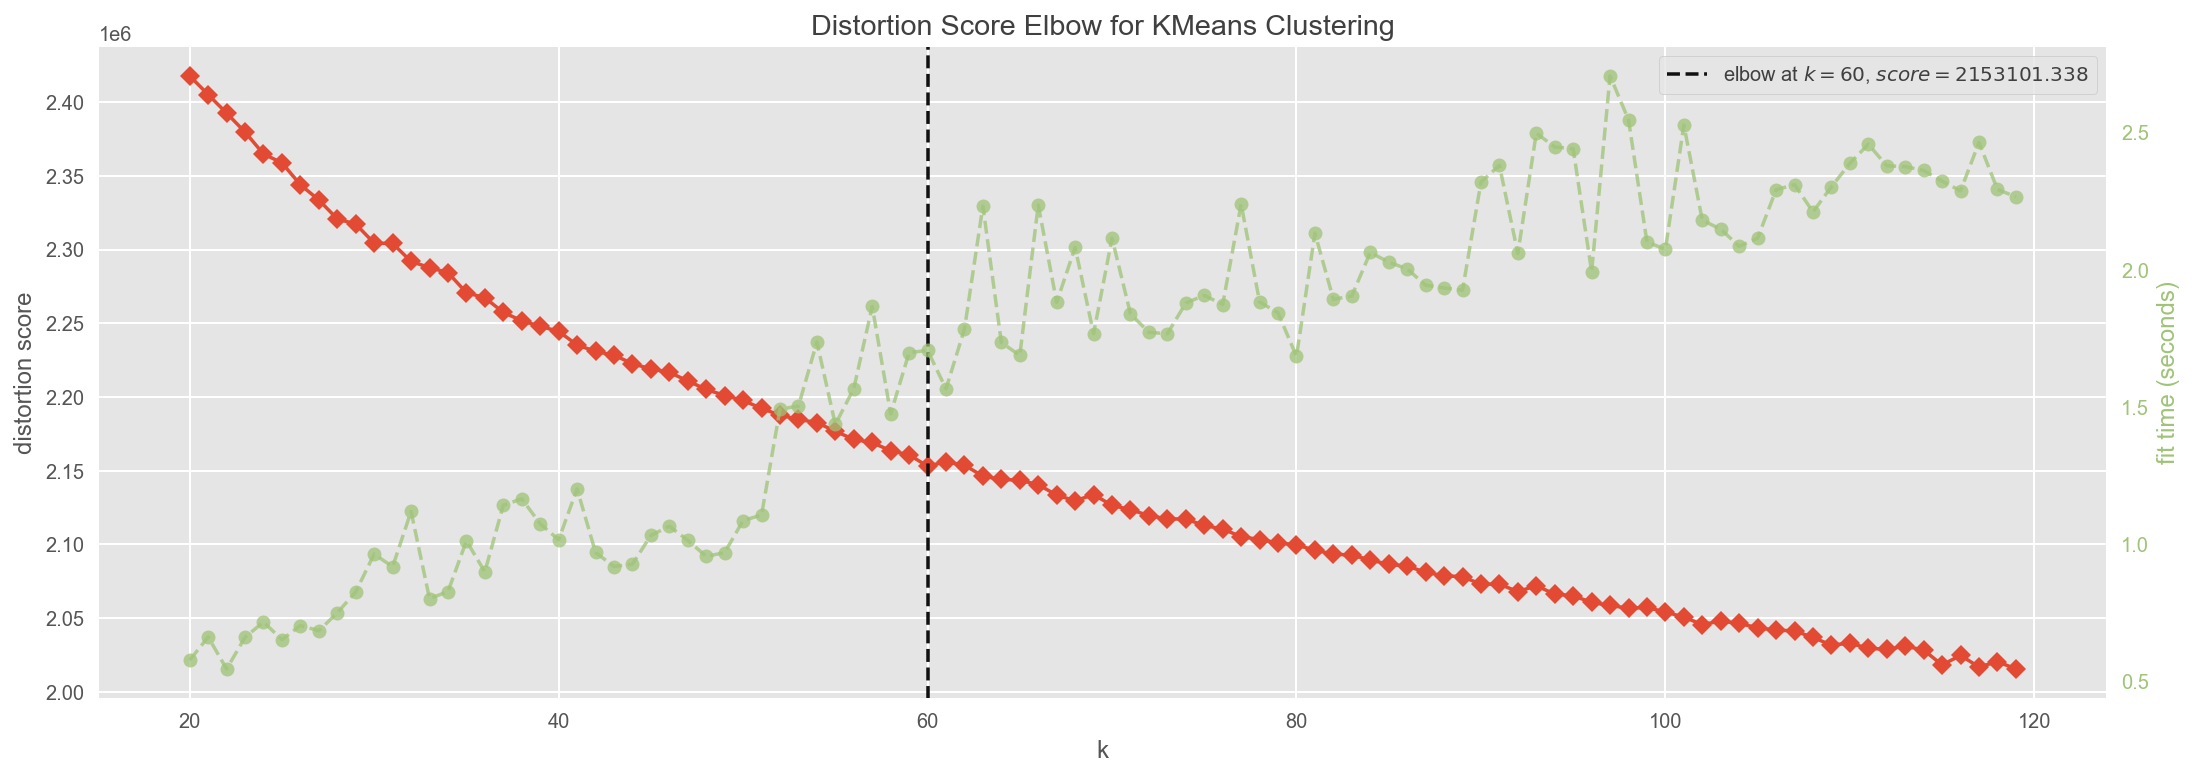

CPU times: user 14min 33s, sys: 5min 19s, total: 19min 53s
Wall time: 2min 49s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
%%time
model = KMeans()
visualizer = KElbowVisualizer(model, k=(20,120))
visualizer.fit(np.array(doc_vectors))
visualizer.show()

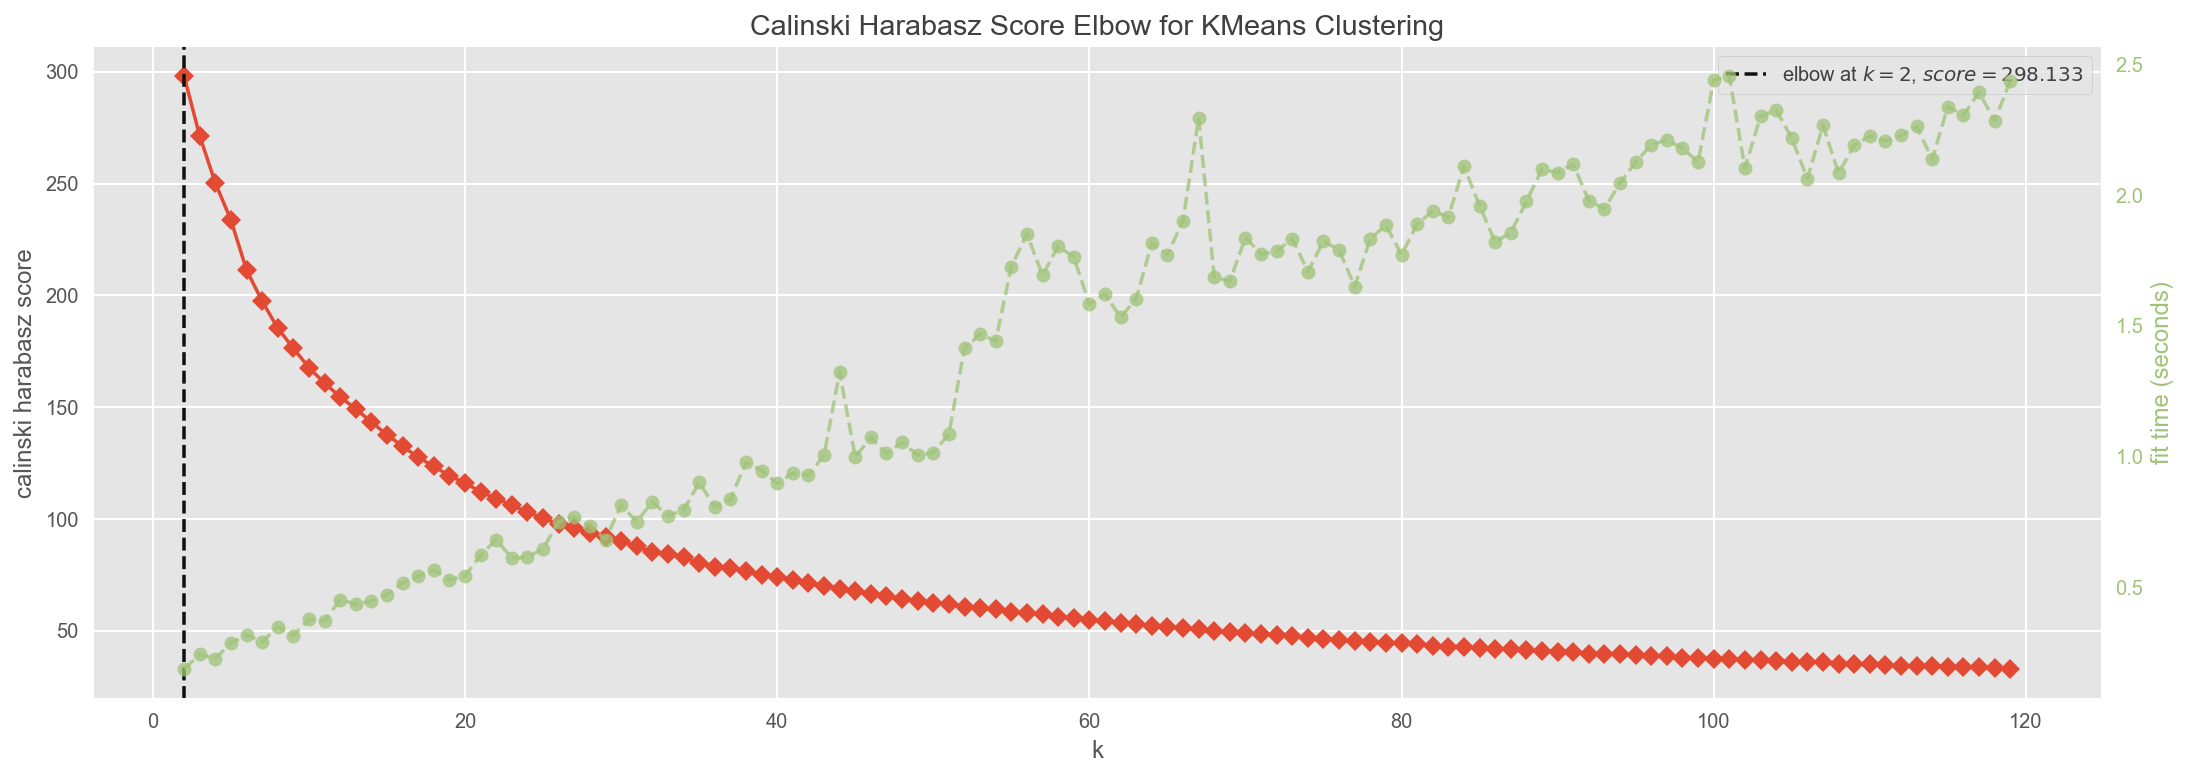

CPU times: user 14min 34s, sys: 5min 4s, total: 19min 39s
Wall time: 2min 49s


<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [64]:
%%time
model = KMeans()
visualizer = KElbowVisualizer(model, metric='calinski_harabasz', k=(2,120))
visualizer.fit(np.array(doc_vectors))
visualizer.show()

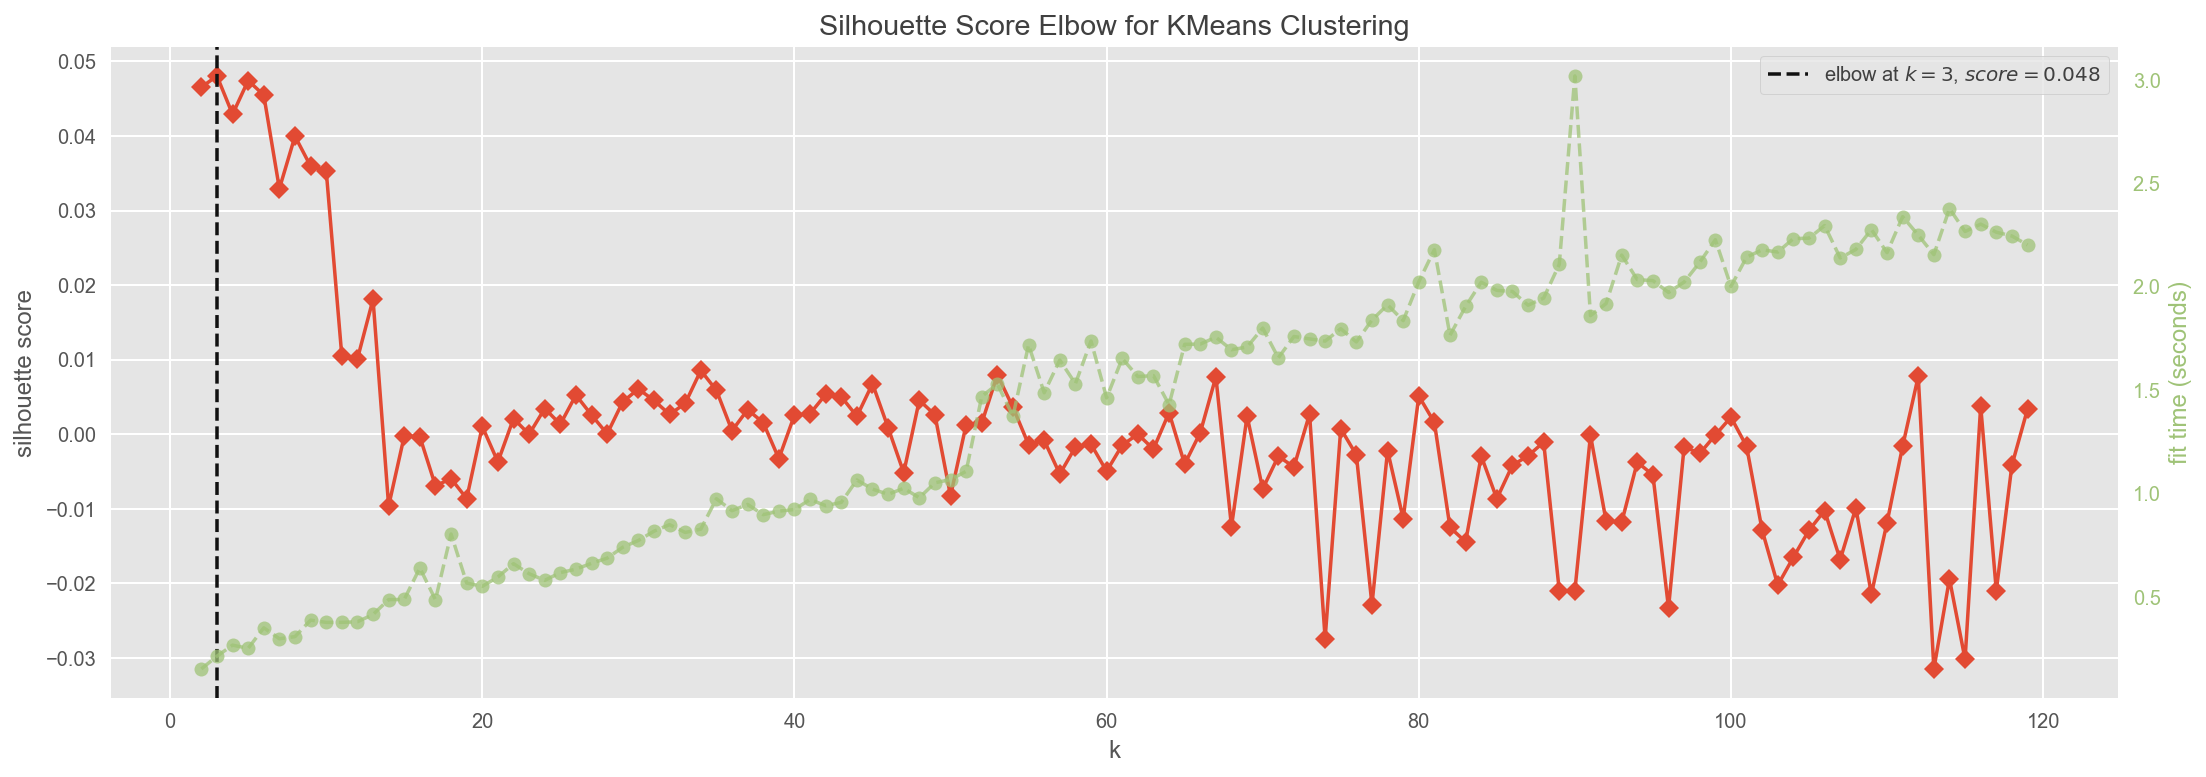

CPU times: user 17min 40s, sys: 6min 38s, total: 24min 19s
Wall time: 3min 25s


<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [65]:
%%time
model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', k=(2,120))
visualizer.fit(np.array(doc_vectors))
visualizer.show()

In [66]:
# Add some more features from the original dataframe to extend the hover labels in the plotly graph.
df_embed_umap["artistName"] = df.artistName
df_embed_umap["title"] = df.title
df_embed_umap["subtitle"] = df.subtitle
df_embed_umap["summary"] = df.summary

In [67]:
# Fit KMeans to the data. Using the estimated value of 30 for n_clusters.
kmeans = KMeans(n_clusters=50).fit(doc_vectors)

- The clustering with KMeans did not yield any substantial additional insight. 
- However, plotting the UMAP projection with plotly and making use of the graph's hover labels allows for a more detailed inspection of the data.

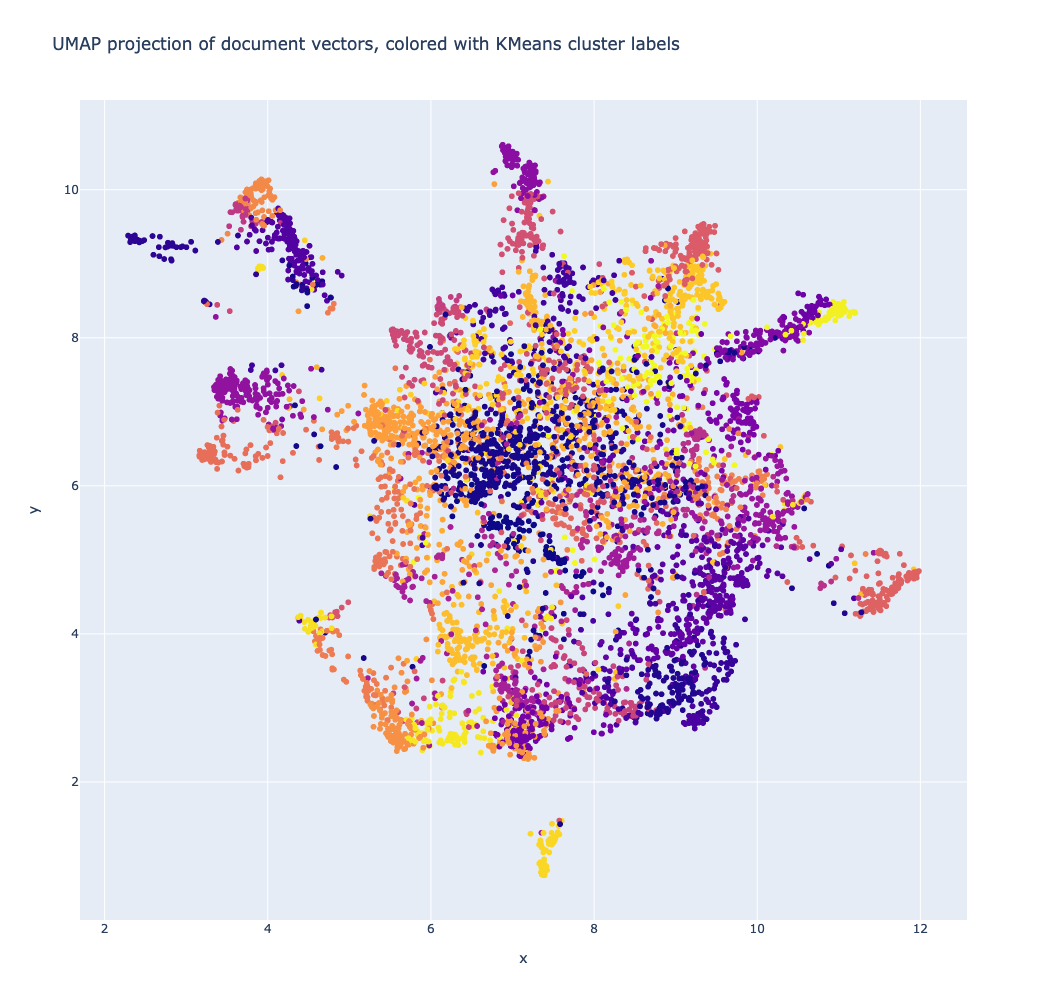

In [70]:
fig = px.scatter(data_frame=df_embed_umap, 
                 x="x", y="y", 
                 width=1400, height=1000,
                 color=kmeans.labels_,
                 title="UMAP projection of document vectors, colored with KMeans cluster labels",
                 # text="title", 
                 hover_data=df_embed_umap[["artistName", "title", "subtitle"]], 
                )
fig.update_coloraxes(showscale=False)
fig.show()

# Conclusions

- Doc2Vec allows for fast embedding of whole documents while resolving some of the shortcomings of a bag-of-word model.
- The order of words is maintained and the meaning of words is learned in context.
- By validating the vector distribution with averaged genre vectors I can see that the learnt distribution is meaningful.
- By looking at (dis-)similarity searches I could further validate the expressiveness of the trained model.